# Music Recommender System using Spotify Playlist Data

- Unsupervised Algorithms in Machine Learning Final Project
- Viacheslav Sergeev <viacheslav.sergeev@colorado.edu>
- University of Colorado Boulder

## Problem Statement

In this project, I develop a music recommender engine solving it as an unsupervised machine learning problem. I use songs, artists, and playlists as features to build an effective recommendation system that recommends new songs to users based on their listening history and listening history of other users.

## Data

I use Kaggle dataset Spotify Playlists ([link](https://www.kaggle.com/datasets/andrewmvd/spotify-playlists)) by andrewmvd. Project development date is 11/03/24. I'm not using any code related to this dataset for development.

### Kaggle Description

> Music is ubiquitous in today's world-almost everyone enjoys listening to music. With the rise of streaming platforms, the amount of music available has substantially increased. While users may seemingly benefit from this plethora of available music, at the same time, it has increasingly made it harder for users to explore new music and find songs they like. Personalized access to music libraries and music recommender systems aim to help users discover and retrieve music they like and enjoy. This dataset is based on the subset of users in the #nowplaying dataset who publish their #nowplaying tweets via Spotify. In principle, the dataset holds users, their playlists and the tracks contained in these playlists.

### Columns

The csv-file holding the dataset contains the following columns:
"user_id", "artistname", "trackname", "playlistname"
, where
- user_id is a hash of the user's Spotify user name
- artistname is the name of the artist
- trackname is the title of the track and
- playlistname is the name of the playlist that contains this track.




## 1. Exploratory Data Analysis
### 1.1 Data Loading
#### 1.1.1 Kaggle API

I download the dataset directly from Kaggle using their API.

In [ ]:
import kagglehub

path = kagglehub.dataset_download("andrewmvd/spotify-playlists")

print("Path to dataset files:", path)


Path to dataset files: /root/.cache/kagglehub/datasets/andrewmvd/spotify-playlists/versions/1


#### 1.1.2 Imports

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string
import re

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split
from sklearn.decomposition import NMF
from sklearn.preprocessing import normalize

from sklearn.cluster import KMeans
from sklearn.metrics import precision_score, recall_score, ndcg_score

import warnings
warnings.filterwarnings('ignore')

nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

### 1.1.3 Data Sampling

Original dataset is giant and has >12M rows. I'm using Google Colab env with 334GB RAM TPU and even 5% sampling is reaching 100GB RAM. Recommendation systems are always compute-heavy but despite performance downgrade I have to sample because of compute limits.

In [ ]:
import pandas as pd
import random
import os
filename = os.listdir(path)[0]
dataset_path = os.path.join(path, filename)

# ref: https://stackoverflow.com/questions/22258491/read-a-small-random-sample-from-a-big-csv-file-into-a-pandas-data-frame
df = pd.read_csv(
    dataset_path,
    skiprows=lambda i: i>0 and random.random() > 0.05,
    on_bad_lines='skip',
    header=0
    )

df.head()

,user_id,"""artistname""","""trackname""","""playlistname"""
0,9cc0cfd4d7d7885102480dd99e7a90d6,Joshua Radin,I'd Rather Be With You [Radio Edit],HARD ROCK 2010
1,9cc0cfd4d7d7885102480dd99e7a90d6,Joshua Radin,Only You,HARD ROCK 2010
2,9cc0cfd4d7d7885102480dd99e7a90d6,The Coronas,San Diego Song,HARD ROCK 2010
3,07f0fc3be95dcd878966b1f9572ff670,C418,Droopy Likes Ricochet,C418
4,07f0fc3be95dcd878966b1f9572ff670,Glen Porter,29 Palms,Chill out


### 1.2 Exploratory Data Analysis
#### 1.2.1 Column Names Cleaning
For some reason we have whitespaces and quotes in column names.

In [ ]:
df.columns = [column.strip().replace('"','') for column in df.columns.tolist()]

#### 1.2.2 Data Overview

In [ ]:
df

,user_id,artistname,trackname,playlistname
0,9cc0cfd4d7d7885102480dd99e7a90d6,Joshua Radin,I'd Rather Be With You [Radio Edit],HARD ROCK 2010
1,9cc0cfd4d7d7885102480dd99e7a90d6,Joshua Radin,Only You,HARD ROCK 2010
2,9cc0cfd4d7d7885102480dd99e7a90d6,The Coronas,San Diego Song,HARD ROCK 2010
3,07f0fc3be95dcd878966b1f9572ff670,C418,Droopy Likes Ricochet,C418
4,07f0fc3be95dcd878966b1f9572ff670,Glen Porter,29 Palms,Chill out
...,...,...,...,...
643572,2302bf9c64dc63d88a750215ed187f2c,Meat Puppets,Backwater,iPhone
643573,2302bf9c64dc63d88a750215ed187f2c,Jane's Addiction,Been Caught Stealing,iPhone
643574,2302bf9c64dc63d88a750215ed187f2c,Robin Trower,Bridge Of Sighs - 2007 Remastered Version,iPhone
643575,2302bf9c64dc63d88a750215ed187f2c,Velvet Revolver,Fall To Pieces,iPhone


#### 1.2.3 Data Uniqueness

In [ ]:
print(f"Number of rows: {df.shape[0]}")
print(f"Number of unique users: {df['user_id'].nunique()}")
print(f"Number of unique artists: {df['artistname'].nunique()}")
print(f"Number of unique tracks: {df['trackname'].nunique()}")
print(f"Number of unique playlists: {df['playlistname'].nunique()}")

Number of rows: 713579
Number of unique users: 14517
Number of unique artists: 76991
Number of unique tracks: 294005
Number of unique playlists: 95918


#### 1.2.4 Missing Rate

In [ ]:
df.isnull().sum()

,0
user_id,0
artistname,1616
trackname,6
playlistname,65


### 1.3 EDA - Visualizations
#### 1.3.1 Tracks per User

In [ ]:
tracks_per_user = df.groupby('user_id')['trackname'].count()
tracks_per_user = tracks_per_user.reset_index()
tracks_per_user = tracks_per_user[tracks_per_user['trackname'] < 200]

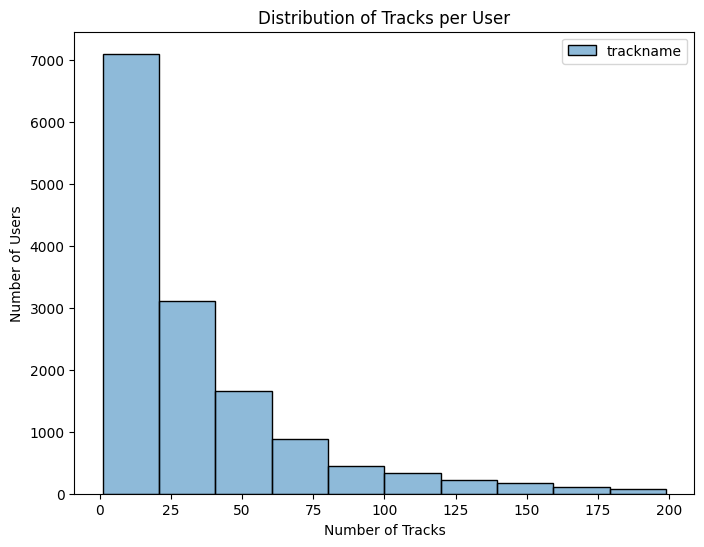

In [ ]:
plt.figure(figsize=(8, 6))
sns.histplot(tracks_per_user, bins=10, kde=False)
plt.title('Distribution of Tracks per User')
plt.xlabel('Number of Tracks')
plt.ylabel('Number of Users')
plt.show()

#### 1.3.2 Top Artists

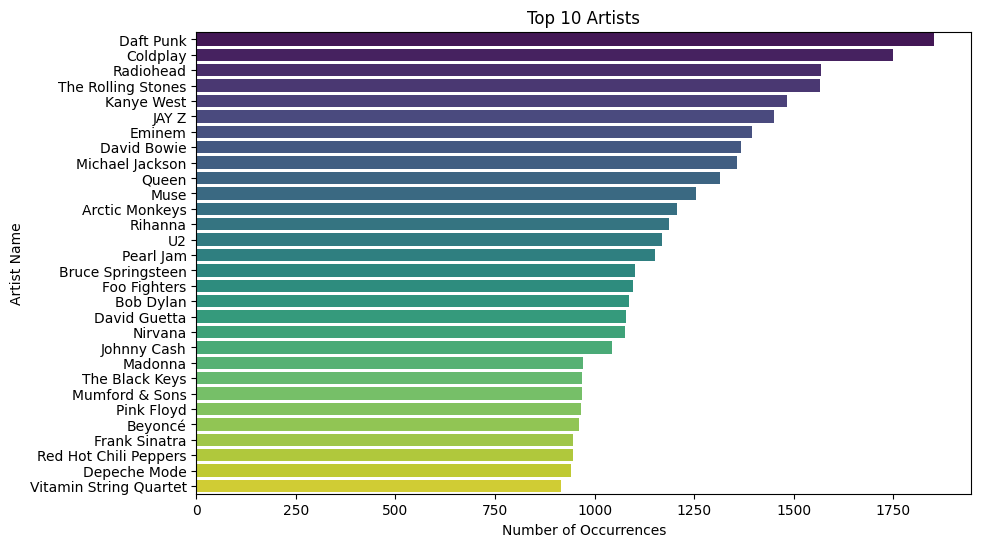

In [ ]:
top_artists = df['artistname'].value_counts().head(30)

plt.figure(figsize=(10, 6))
sns.barplot(y=top_artists.index, x=top_artists.values, palette='viridis')
plt.title('Top 10 Artists')
plt.xlabel('Number of Occurrences')
plt.ylabel('Artist Name')
plt.show()

### 1.4 Feature Engineering
#### 1.4.1 Artists Cleaning

Except user interactions itself we have the text data like playlist and artists names that we potentially can use building our recommendation system. I apply NLP techniques for data cleaning.

In [ ]:
df['artistname'] = df['artistname'].str.lower()
df['trackname'] = df['trackname'].str.lower()
df['playlistname'] = df['playlistname'].str.lower()

In [ ]:
df = df.dropna()

#### 1.4.2 Artists Separation

Sometimes artists collab and if we will use artists as a feature we should consider collaborations of artists A&B similar to both A and B.

In [ ]:
def split_artists(artist):
    return re.split(r'\s*(?:&|and|feat\.?|ft\.?|x)\s*', artist)

df['artistname'] = df['artistname'].apply(split_artists)
df = df.explode('artistname')
df['artistname'] = df['artistname'].str.strip()

#### 1.4.1 Lemmatization

Applying basic NLP techniques in case I will use playlist names similarity as a features.

In [ ]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    text = text.translate(str.maketrans('', '', string.punctuation))
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return ' '.join(tokens)

df['playlistname_processed'] = df['playlistname'].apply(preprocess_text)

In [ ]:
df

,user_id,artistname,trackname,playlistname,playlistname_processed
0,9cc0cfd4d7d7885102480dd99e7a90d6,joshua radin,i'd rather be with you [radio edit],hard rock 2010,hard rock 2010
1,9cc0cfd4d7d7885102480dd99e7a90d6,joshua radin,only you,hard rock 2010,hard rock 2010
2,9cc0cfd4d7d7885102480dd99e7a90d6,the coronas,san diego song,hard rock 2010,hard rock 2010
3,07f0fc3be95dcd878966b1f9572ff670,c418,droopy likes ricochet,c418,c418
4,07f0fc3be95dcd878966b1f9572ff670,glen porter,29 palms,chill out,chill
...,...,...,...,...,...
643572,2302bf9c64dc63d88a750215ed187f2c,meat puppets,backwater,iphone,iphone
643573,2302bf9c64dc63d88a750215ed187f2c,jane's addiction,been caught stealing,iphone,iphone
643574,2302bf9c64dc63d88a750215ed187f2c,robin trower,bridge of sighs - 2007 remastered version,iphone,iphone
643575,2302bf9c64dc63d88a750215ed187f2c,velvet revolver,fall to pieces,iphone,iphone


## 2. Analysis
## 2.1 Models Building
### 2.1.1 Users Similarity

I build a matrix users x tracks. In this case, every user has embedding of songs they listen. Recommended songs in this engine design are tracks listened by similar users (users with similar embeddings). I build such a matrix using df pivot, then calculate similarity of users.

In [ ]:
interaction_matrix = df.pivot_table(
    index='user_id', columns='trackname',
    values='artistname', aggfunc='count'
    ).fillna(0)


In [ ]:
user_similarity = cosine_similarity(interaction_matrix)
user_similarity_df = pd.DataFrame(
    user_similarity, index=interaction_matrix.index,
    columns=interaction_matrix.index
    )

In [ ]:
def user_based_recommendation(user_id, interaction_matrix, user_similarity_df, k=10):
    user_songs_list = interaction_matrix.loc[user_id]
    already_listened = user_songs_list[user_songs_list > 0].index.tolist()

    if len(interaction_matrix) <= 1:
        return []

    similarity_scores = user_similarity_df[user_id].drop(user_id, errors='ignore')
    similar_users = sim_scores[similarity_scores > 0].sort_values(ascending=False).index.tolist()

    if not similar_users:
        return []

    similar_users_songs = interaction_matrix.loc[similar_users]
    song_scores = similar_users_songs.sum(axis=0)
    song_scores = song_scores.drop(already_listened, errors='ignore')
    recommended_songs = song_scores.sort_values(ascending=False).head(k).index.tolist()

    return recommended_songs

### 2.1.2 Dimensionality Reduction

The second model follows the same recommendation engine design but should perform faster because of dimensionality reduction.

In [ ]:
svd = TruncatedSVD(n_components=15, random_state=42)
latent_matrix = svd.fit_transform(interaction_matrix)
reconstructed_matrix = np.dot(latent_matrix, svd.components_)
reconstructed_df = pd.DataFrame(
    reconstructed_matrix,
    index=interaction_matrix.index,
    columns=interaction_matrix.columns
    )


In [ ]:
def matrix_factorization_recommendation(user_id, reconstructed_df, k=10):
    if user_id not in reconstructed_df.index:
        return []

    user_songs = reconstructed_df.loc[user_id]
    user_songs_sorted = user_songs.sort_values(ascending=False)
    recommended_songs = user_songs_sorted.head(k).index.tolist()
    return recommended_songs

### 2.2 Models Evaluation
#### 2.2.1 Train/test Split

The data is tricky, we have interactions of users and we need to exclude specified % of test data interaction for every user. The data is pretty big and we have to do this efficiently to don't spend too much time and compute on this basic operation.

In [ ]:
def train_test_split_user(data, test_size=0.2, random_state=42):
    np.random.seed(random_state)

    user_counts = data['user_id'].value_counts()

    users_train_all = user_counts[user_counts < 2].index
    users_split = user_counts[user_counts >= 2].index
    train_data = data[data['user_id'].isin(users_train_all)]
    split_data = data[data['user_id'].isin(users_split)].copy()
    split_data['is_test'] = split_data.groupby('user_id')['user_id'].transform(
        lambda x: np.random.rand(len(x)) < test_size
    )

    test_data = split_data[split_data['is_test']].drop(columns=['is_test'])
    train_split = split_data[~split_data['is_test']]

    train_data = pd.concat([train_data, train_split])

    return train_data.reset_index(drop=True), test_data.reset_index(drop=True)

train_df, test_df = train_test_split_user(df)


We need a separate matrix of user interactions that doesn't use interactions from the train data.

In [ ]:
train_interaction_matrix = train_df.pivot_table(
    index='user_id', columns='trackname',
    values='artistname', aggfunc='count'
    ).fillna(0)

### 2.3 Metrics
#### 2.3.1 Precision
The proportion of recommended items in the top k (10 in my case) that are relevant.

In [ ]:
def precision_at_k(recommended, relevant, k):
    if not recommended:
        return 0.0
    recommended_at_k = recommended[:k]
    relevant_set = set(relevant)
    recommended_set = set(recommended_at_k)
    precision = len(recommended_set & relevant_set) / min(k, len(recommended_at_k))
    return precision

#### 2.3.2 Recall

Measures the proportion of relevant items retrieved in the top recommendations.

In [ ]:
def recall_at_k(recommended, relevant, k):
    if not relevant:
        return 0.0
    recommended_at_k = recommended[:k]
    relevant_set = set(relevant)
    recommended_set = set(recommended_at_k)
    recall = len(recommended_set & relevant_set) / len(relevant_set)
    return recall

#### 2.3.3 Normalized Discounted Cumulative Gain

Measures the ranking quality by assigning higher weights to relevant items that appear earlier in the recommendations.

In [ ]:
def ndcg_at_k(recommended, relevant, k):
    if not relevant:
        return 0.0
    dcg = 0.0
    for i, rec in enumerate(recommended[:k]):
        if rec in relevant:
            dcg += 1 / np.log2(i + 2)
    idcg = sum([1 / np.log2(i + 2) for i in range(min(len(relevant), k))])
    return dcg / idcg if idcg > 0 else 0.0

### 2.4 Models Evaluation and Comparison
#### 2.4.1 Model Evaluation for a User

I'm making a prediction for specified user and calculate all of the metrics.

In [ ]:
def evaluate_model(recommend_func, user_id, interaction_matrix, test_df, k=10):
    recommended_songs = recommend_func(user_id, interaction_matrix, k=k)
    test_songs = test_df[test_df['user_id'] == user_id]['trackname'].unique().tolist()

    if not test_songs:
        return None

    precision = precision_at_k(recommended_songs, test_songs, k)
    recall = recall_at_k(recommended_songs, test_songs, k)
    ndcg = ndcg_at_k(recommended_songs, test_songs, k)

    return {'precision': precision, 'recall': recall, 'ndcg': ndcg}

#### 2.4.2 Model Evaluation for Multiple Users

I'm making prediction for N users and analyse distribution of every metric across users to get better sense of the model performance.

In [ ]:
def evaluate_for_multiple_users(lambda_func, users=10):
  results = {
      'precision': [],
      'recall': [],
      'ndcg': []
  }
  for i in range(1,users):
    try:
      user_id = interaction_matrix.index[i]
      evaluation_results = evaluate_model(
          lambda_func,
          user_id,
          train_interaction_matrix,
          test_df,
          k=10
      )
      for metric in ['precision','recall','ndcg']:
        results[metric].append(evaluation_results[metric])
    except:
      pass

  print(results)
  for metric in ['precision','recall','ndcg']:
    measures = results[metric]
    print(f'Metric {metric}: median {round(np.median(measures),2)}, avg \
    {round(np.average(measures),2)}, range {round(np.min(measures),2)}-{round(np.max(measures),2)}')



{'precision': [0.1, 0.0, 0.1, 0.1, 0.1, 0.1, 0.0, 0.2, 0.2], 'recall': [0.5, 0.0, 0.16666666666666666, 0.004484304932735426, 0.25, 0.09090909090909091, 0.0, 0.2222222222222222, 0.10526315789473684], 'ndcg': [0.6131471927654584, 0.0, 0.19092086617893467, 0.11004588314904008, 0.15101961822780524, 0.22009176629808017, 0.0, 0.33627415762678553, 0.2984900352767555]}
Metric precision: median 0.1, avg     0.1, range 0.0-0.2
Metric recall: median 0.11, avg     0.15, range 0.0-0.5
Metric ndcg: median 0.19, avg     0.21, range 0.0-0.61


## 3. Results: Models Evaluation and Comparison

## 3.1 User Based Recommendation

In [ ]:
evaluate_for_multiple_users(
    lambda_func=lambda uid, im, k: user_based_recommendation(uid, im, user_similarity_df, k),
    users=100
)

No similar users found for user 009d6038a80daf642db5d1198b760c58.
No similar users found for user 01429fbf7fb40aaaa3bcb0d621eb25c7.
No similar users found for user 014fe0acb3ceee63fd15f3e5610424de.
{'precision': [0.1, 0.0, 0.1, 0.1, 0.1, 0.1, 0.0, 0.2, 0.2, 0.0, 0.2, 0.3, 0.3, 0.0, 0.0, 0.1, 0.2, 0.0, 0.0, 0.1, 0.2, 0.0, 0.1, 0.1, 0.2, 0.1, 0.0, 0.3, 0.1, 0.1, 0.0, 0.1, 0.1, 0.0, 0.4, 0.1, 0.0, 0.2, 0.2, 0.2, 0.0, 0.2, 0.1, 0.3, 0.1, 0.0, 0.0, 0.1, 0.4, 0.0, 0.2, 0.2, 0.0, 0.2, 0.3, 0.1, 0.1, 0.1, 0.4, 0.2, 0.0, 0.0, 0.0, 0.1, 0.2, 0.0, 0.2, 0.0, 0.1, 0.1, 0.2, 0.1, 0.1, 0.0, 0.3, 0.0], 'recall': [0.5, 0.0, 0.16666666666666666, 0.004484304932735426, 0.25, 0.09090909090909091, 0.0, 0.2222222222222222, 0.10526315789473684, 0.0, 1.0, 0.1875, 0.5, 0.0, 0.0, 0.3333333333333333, 0.5, 0.0, 0.0, 1.0, 0.2857142857142857, 0.0, 0.16666666666666666, 0.3333333333333333, 0.04, 1.0, 0.0, 0.2727272727272727, 0.5, 0.25, 0.0, 0.3333333333333333, 0.25, 0.0, 0.36363636363636365, 0.08333333333333333, 0.0, 

0.1 precision and recall for just 5% sample and 10 recommendations using simplest recommendation method is pretty good

## 3.2 Matrix Factorization

In [ ]:
evaluate_for_multiple_users(
    lambda_func=lambda uid, im, k: matrix_factorization_recommendation(uid, reconstructed_df, k),
    users=100
)


{'precision': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 'recall': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.2, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.125, 0.0, 0.0, 0.0, 0.0, 0.0, 0.03125, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.034482758620689655, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.030303030303030304, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 'ndcg': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.21398626473452756, 0.0, 0.0, 0.0, 0.

0.01 avg precision shows that the model with factorization basically doesn't work

# 4. Results Discussion

First model gives much better results providing 10% relevant recommendations that is good considering the fact that we are using only 5% of the data. Matrix factorization though gives us way worse results but has much better performance calculating recommendations for 100 users for just 4 seconds compared to 2 minutes for full calculation.

Recommendation engine is a trade off between speed/compute and quality of predictions. This trade-off is also driven by amount of available compute and data. I don't have enough compute but have a lot of data. Maybe if I had more compute and was able to use full data instead of sample, factorization method would work better and good enough for actual usage when full calculation for every user would become unacceptable. In this case of production level model, second model would be preferred. But considering compute limitations and that there is no necessity to deploy on production, that I can't use full data, **I think model 1 without factorization is better**.

Also, I didn't use other recommendation engine methods. Initially I planned to look for similar playlists and recommend from similar playlists. Similarity of playlist could be calculated using names similarity, content similarity. Artists dimensions isn't touched. It's also possible to clusterize artists, users, playlists for more complex analysis. But the dataset is so big and heavy to compute that I decided to use only simple methods.